In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pyshtools as pysh
import SLmod as SL
from numpy import pi as pi

#set plotting parameters
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [16, 8]

We start by setting the truncation degree for the calculations

In [35]:
L=256

Next we read in the initial sea level, $SL$, and ice thickness, $I$, from a data file. These variables are stored on a real Gauss-Legendre grid. They can be plotted showing coastlines using SL.geo_plot() whose second argument selects the colourmap used.

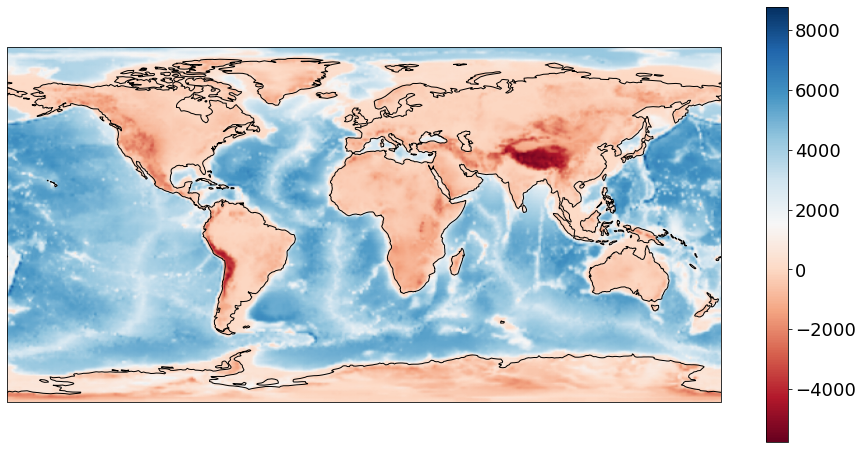

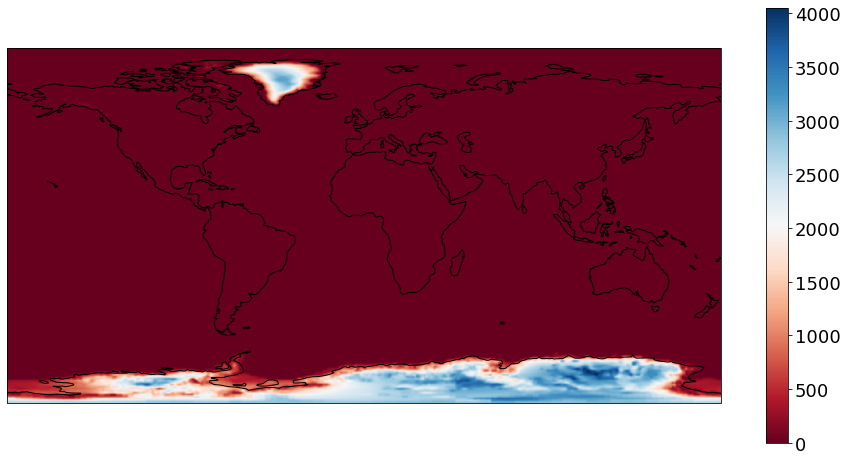

In [36]:
sl0,ice0 = SL.get_sl_ice_data(L)
SL.geo_plot(sl0)
SL.geo_plot(ice0)

From the sea level and ice, we can compute the ocean area. Note that the ocean function is defined to equal one where there is to equal one where water is present and zero elsewhere. Based on a simple isostatic balance between the water and ice, we have
\begin{equation}
C(\theta,\varphi) = \left\{
\begin{array}{cc}
1 & \rho_{w} SL(\theta,\varphi) \ge \rho_{i} I(\theta,\varphi) \\
0 & \rho_{w} SL(\theta,\varphi) < \rho_{i} I(\theta,\varphi) 
\end{array}
\right.
\end{equation}
The ocean area is then defined as
\begin{equation}
A = \int_{\partial M} C\, \mathrm{d} S.
\end{equation}


In [37]:
C = SL.ocean_function(sl0,ice0)
A = SL.surface_integral(C)
A_earth = 4*pi*SL.b**2
print('fraction of surface which is ocean = ',A/A_earth)

fraction of surface which is ocean =  0.7129602337196239


We now set the ice to be melted, taking as an example a reduction in the height of the Greenland ice sheet by 1%. This can be done as follows:


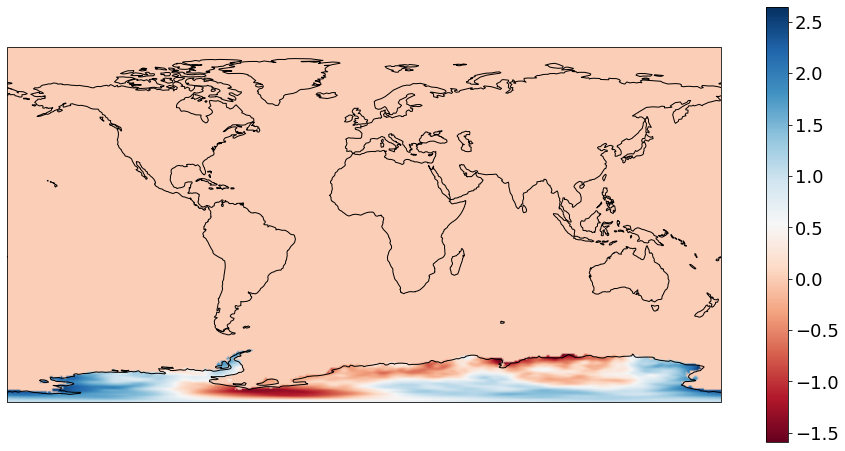

In [40]:
# set covariance for a random field
Q = SL.laplace_covariance(L,std = 1.,s = 2,mu = 0.2) 

# build a random melt geometry
ice = SL.random_field(Q)*SL.antarctica_mask(C,ice0,0.)

# plot the result with suitable mask
ice_mask = SL.ice_mask(C,ice0)
SL.geo_plot(ice)

Having now defined the problem to be solved, we can solve the sea level equation by calling the following function. Note that it returns perturbations to (at the chosen trunction degree) the sea level change, $SL$, the vertical displacement, $u$, the gravitational potential, $\phi$, and the centrifugal potential, $\psi$ (the latter two plotted as the equivalent change in sea level by scaling by $-1/g$).

iteration =  1 relative change =  0.04787106327329938
iteration =  2 relative change =  0.007713337810384307
iteration =  3 relative change =  0.0016290997514528545
iteration =  4 relative change =  0.0004302141289504759
iteration =  5 relative change =  0.00011106952767855621
iteration =  6 relative change =  2.8189874707614016e-05
iteration =  7 relative change =  7.067636686996454e-06
iteration =  8 relative change =  1.7583765933171587e-06
iteration =  9 relative change =  4.3621900616152994e-07


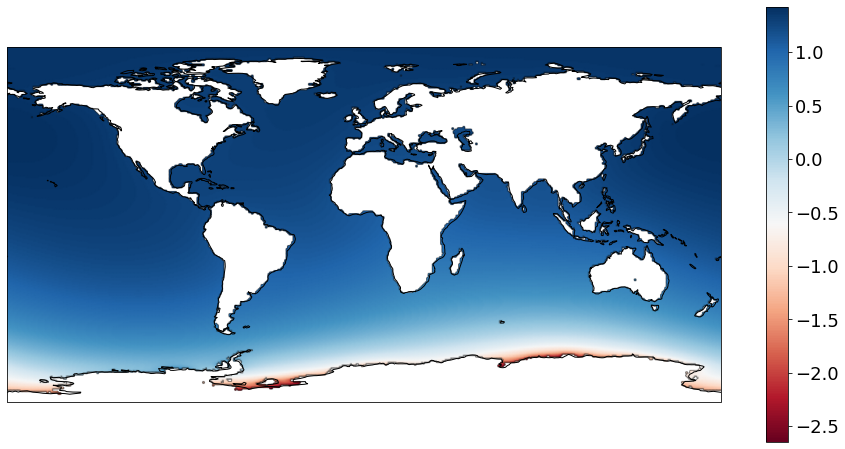

In [39]:
# set the direct load
zeta   = SL.rhoi*(1-C)*ice
# solve the fingerprint problem
sl,_,_,om,_ = SL.fingerprint(C,zeta)
slu = np.abs(SL.ocean_integral(C,sl)/SL.surface_integral(C))
ocean_mask = SL.ocean_mask(C)
SL.geo_plot(ocean_mask*sl/slu)


iteration =  1 relative change =  0.01626610345318053
iteration =  2 relative change =  0.0007594889458318523
iteration =  3 relative change =  0.0001129563161060711
iteration =  4 relative change =  2.6000844009211064e-05
iteration =  5 relative change =  6.147960811269442e-06
iteration =  6 relative change =  1.4403562025965943e-06
iteration =  7 relative change =  3.366337622740393e-07


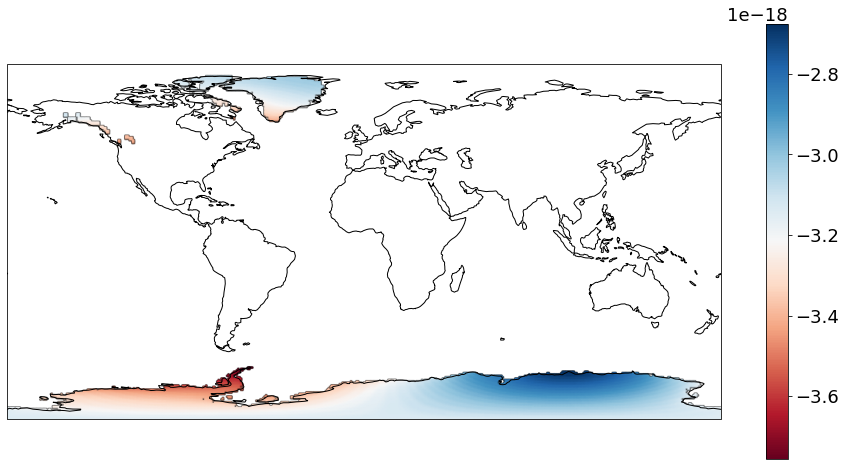

0.029954606927801605 0.029954650889744184 1.4676187434303142e-06


In [41]:
# set the observation point and set the adjoint loads
lats = np.zeros(1)
lons = np.zeros(1)
w = np.zeros(1)
lats[0] =  1.35
lons[0] =  103.8
zeta_d   = SL. point_load(L,lats,lons,angle = 1.0)

# act the adjoint load on the sea level to get the observation
J =   SL.surface_integral(zeta_d*sl) 

sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)
SL.geo_plot(ice_mask*sl_d)


# act the load on the adjoint sea level
J2 =   SL.surface_integral(zeta*sl_d)          

# compare the two values
print(J,J2,np.abs(J-J2)/np.abs(J))